### Using hist to group probability

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.interpolate import Rbf
folder_path = '../../datasets/rawdata'
prob_folder_path = '../../datasets/probability'
FLB_folder_path = '../../datasets/FLB'
resam_folder_path = '../../datasets/resample_by_min'
games = { 'baseball':'/baseball/mlb','basketball':'/basketball/nba','football':'/football/nfl',
            'iceball': '/iceball/nhl','soccer_champion':'/soccer/champ_league','scoccer_england':'/soccer/epl',
            'soccer_major':'/soccer/majorleague'}
# folder name is games, result name is games_results.csv

games_list = ['baseball','iceball',
              'soccer_champion','scoccer_england','soccer_major',
              'soccer',
              'soccer_home','soccer_away','soccer_draw']

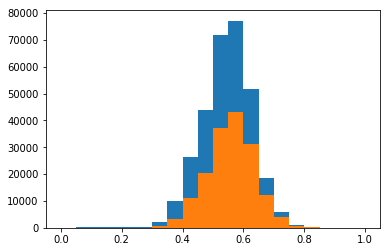

In [62]:
# choose bin and load
bins_num=20
game_name = 'baseball'
count_df = pd.read_csv(FLB_folder_path+'/summary/'+game_name+'.csv').set_index('Unnamed: 0')

counts, middiam, objs = plt.hist(count_df.iloc[:,0],range=(0,1),bins=bins_num)
win_counts, middiam, objs = plt.hist(count_df[count_df['HOME_WIN']==True].iloc[:,0],range=(0,1),bins=bins_num)
# the percentage of winners
perc_winners = win_counts/(counts+1e-8)
time_period = (middiam[1]-middiam[0])/2
probabilities = [i + time_period for i in middiam[:-1]]


In [63]:
counts

array([4.9000e+01, 2.5500e+02, 1.5100e+02, 1.7900e+02, 1.6100e+02,
       4.6700e+02, 2.1480e+03, 9.8240e+03, 2.6533e+04, 4.3872e+04,
       7.1619e+04, 7.7110e+04, 5.1750e+04, 1.8436e+04, 5.8050e+03,
       9.6800e+02, 1.5800e+02, 7.8000e+01, 9.8000e+01, 1.0500e+02])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=20, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=25, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=30, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


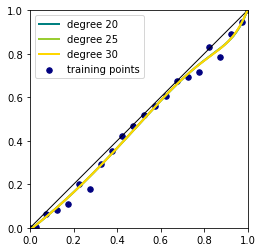

In [64]:
nonsample_list = [i for i in range(len(counts)) if counts[i]<3]
mtc = np.append(np.delete(np.array([probabilities,perc_winners]), nonsample_list, 1),[[0,1],[0,1]],axis=1)

# non-linear
x = mtc[0,:]
y = mtc[1,:]
colors = ['teal', 'yellowgreen', 'gold']

g = plt.scatter(x,y, color='navy', s=30, marker='o', label="training points")
x_plot = np.linspace(0, 1, 1000)
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]
g = plt.plot([0,1], [0,1], color='k', linewidth=1)
for count, degree in enumerate([20, 25, 30]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.01))
    model.fit(X,y)
    y_plot = model.predict(X_plot)
    g = plt.plot(X_plot, y_plot, color=colors[count], linewidth=2,
             label="degree %d" % degree)
g = plt.legend(loc='upper left')
g = plt.ylim(0,1)
g = plt.xlim(0,1)
g = plt.axes().set_aspect('equal')
plt.show()

(0, 1)

(0, 1)

C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


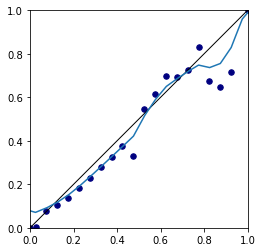

In [14]:
# smooth
smoothy = Rbf(x, y,function='linear',epsilon =0.4,smooth=0.2)
power_smooth = smoothy(x_plot)
plt.scatter(x,y, color='navy', s=30, marker='o', label="training points")
plt.plot([0,1], [0,1], color='k', linewidth=1)
plt.plot(x_plot,power_smooth) 
plt.ylim(0,1)
plt.xlim(0,1)
plt.axes().set_aspect('equal')
plt.show()  

# count by windows
set window's width, go through whole set and group all obvers in this windows to count. Calculate the percentage of winners in this windows as this of median one.

median $\in$ $[ 0, 1 ]$

In [49]:
def generate_percentage_winners(count_df,windows_weight):
    perc_winnners_obv = pd.DataFrame(columns = ['price','perc_winner'])
    medians = np.array(range(101))/100
#     perc_winnners_obv = perc_winnners_obv.append({'price':0.0,'perc_winner':0.0},ignore_index =True)
    for median in medians:
        window_low = median - windows_weight
        window_high = median + windows_weight
        obv_in_windows = count_df[(count_df.iloc[:,0]<=window_high) & (count_df.iloc[:,0]>=window_low)]
        win_obv_in_windows = obv_in_windows[obv_in_windows['HOME_WIN']==True]
        if len(obv_in_windows) < 1:
            continue
        percentage_ = round(len(win_obv_in_windows)/len(obv_in_windows),3)
#         perc_winnners_obv[median] = percentage_
        perc_winnners_obv = perc_winnners_obv.append({'price':median,'perc_winner':percentage_},ignore_index =True)
#     perc_winnners_obv = perc_winnners_obv.append({'price':1.0,'perc_winner':1.0},ignore_index =True)
    return perc_winnners_obv

In [56]:
windows_weight = 0.05
for game_name in [ 'baseball']:
# for game_name in [ 'soccer_home','soccer_away','soccer_draw']:
    count_df = pd.read_csv(FLB_folder_path+'/summary/'+game_name+'.csv').set_index('Unnamed: 0')
    perc_ = generate_percentage_winners(count_df,windows_weight)
#     perc_.to_csv(FLB_folder_path+'/'+game_name+'_'+str(windows_weight)+'_.csv',index=False)

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

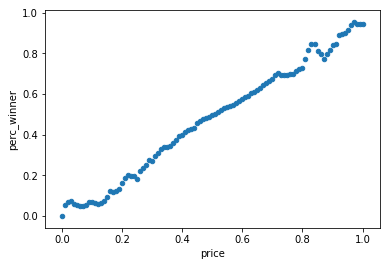

In [65]:
perc_.plot.scatter(x=0,y=1)